___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 


# SEGUNDO EXAMEN PARCIAL
# SIMULACIÓN DE PROCESOS FINANCIEROS

## Examen Tema 2
## Nombre: Márquez Delgado Esteban if700637

## Fecha: 7 de noviembre del 2021

## Por: Oscar David Jaramillo Z.

In [1]:
# Librerías 
# Análisis y manejo de datos
import pandas as pd
import numpy as np
# Visualización
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Optimización
from scipy import optimize
# KDE
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
# Paquetes de estadística
from sklearn import metrics
import statsmodels.api as sm
import scipy.stats as st
import scipy.special as sps 
# Filtrado de alertas
import warnings
warnings.filterwarnings("ignore")

# 1.
Usando la información reportada en el archivo `Datos_a.csv`, responda las siguientes preguntas:

a) **Para la columna 1 de su archivo `Datos_a.csv`**, utilice el método de **kernel density estimation** de su preferencia para ajustar una distribución de probabilidad a este conjunto de datos. Posteriormente, utilizar el método de **aceptación y rechazo** para **generar 100 muestras aleatorias**, implementando los **tres métodos de reducción de varianza** vistos en clase. Posteriormente, graficar el **histograma** de los valores aleatorios obtenidos con el método de aceptación y rechazo (de *los tres métodos distintos) y la distribución de probabilidad obtenida con el kernel density estimation*, los resultados se deben de reportar como sigue (tres gráficas distintas).

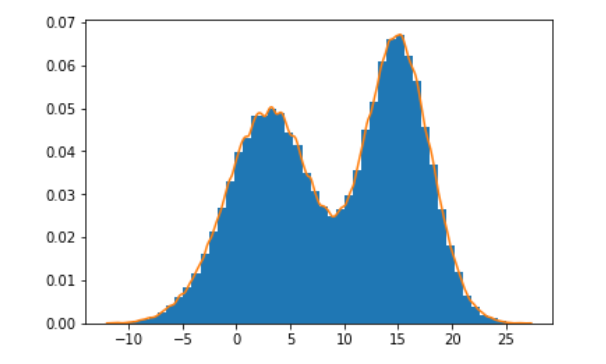

In [2]:
#Funciones a utilizar
def kde(data : "Datos", bw : "Bandwidth", kfolds : "K-folds", x_grid : "Dominio", title : "Título del gráfico", 
        color : "Color del gráfico"):
    """ 
    Definición: Método no paramétrico para estimar la función de densidad de probabilidad (PDF) de los datos ingresados.
    Variables:  
    +data : Son los datos con los que se trabajará.
    +bw : Es la línea de suavizado óptima en el rango de la sig. manera:
    np.linspace(bw mín., bw. max., bws entre el min. y el max.).
    +kfolds : Número de particiones para la optimización.
    +x_grid : El dominio de los datos:
    np.arange(dato mínimo, dato máximo, paso).
    +title : El título del gráfico.
    +color : Son los colores expresos de la sig. manera: [color 1, color 2].
    """
    
    model = GridSearchCV(KernelDensity(), {'bandwidth': bw}, cv = kfolds)
    model.fit(data[:, None]) # Búsqueda exhaustiva de valores con parámetros especificados para un estimador.
    
    bestModel = model.best_estimator_ 
    pdf = lambda x : np.exp(bestModel.score_samples(x[:, None])) #Probability density function de data ajustada.
    
    bwOpt = bestModel.bandwidth # Obtención del parámetro de suavizado óptimo
    # Estética del gráfico 
    plt.figure(figsize = (9, 5)) #Tamaño 
    plt.title(title) #Título
    plt.plot(x_grid, pdf(x_grid), label = "Bandwidth: " + str(round(bwOpt, 2)), color = color[0]) #Gráfico
    plt.hist(data, 100, fc = color[1], histtype = "stepfilled", alpha = 0.25, density = True) #Histograma de data
    plt.legend(loc = "best"); #Label expreso 
    
    return pdf #Regresa la función de densidad de probabilidad (PDF)

def f_max(f : "Función de densidad f(x)"):
    """
    Maximiza la función de densidad f(x): la función anónima t(x) con el máximo de f(x).
    f : es la función de densidad f(x).
    """
    max_f = f(optimize.fmin(lambda x : -f(x), 0, disp=False)) 
    t = lambda x : np.ones(len(x)) * max_f #Función anónima que regresa t(x)
    return t

def acceptanceRejection(f : "Función de densidad f(x)", t : "Función que devuelve el max. de f(x)", interval : "Dominio de f(x)", 
                        N : "Variables aleatorias aceptadas ", 
                        method : "Ingrese el método: Montecarlo, Muestreo estratificado, Números aleatorios complementarios"):
    """
    acceptanceRejection es una lista que contiene a las variables aleatorias aceptadas.
    +f : Es la función de densidad f(x) (pdf) para generar variables aleatorias.
    +t : Máximo de la función de densidad f(x).
    +interval : Dominio de la función de densidad f(x), expreso de la sig manera: [a, b], sabiendo que b > a.
    +N : Es el número de variables aleatorias que se desean aceptar. 
    +method : Es el método de reducción de varianza para la generación de las variables aleatorias R2.
    """
    x_accepted = [] #Número de variables aleatorias aceptadas
    while len(x_accepted) < (N + 1): 
        R1 = np.random.uniform(interval[0], interval[1], N) #Generación de variables aleatorias de una dist. uniforme
        
        if method == "Montecarlo": 
            R2 = np.random.rand(N) #Método de reducción de varianza con Montecarlo.
        elif method == "Muestreo estratificado":
            R2 = (np.random.rand(N) + np.arange(0, N)) / N #Método de reducción de varianza con Muestreo Estratificado
        else:
            U = np.random.rand(int(N / 2)) #Método de reducción de varianza con Números complementarios
            R2 = np.concatenate((U, 1 - U)) #Concatenación de U y su complemento     
        datan = pd.DataFrame() #creación de Dataframe
        datan["R1"] = R1
        datan["R2"] = R2
        datan["f_x"] = f(datan["R1"].values)
        datan["t_x"] = t(datan["R1"].values)
        datan["condition"] = datan["f_x"] >= datan["R2"] * datan["t_x"]
        #Compresión que devuelve el número de variables aleatorias aceptadas   
        [x_accepted.append(R1_i) for R1_i in datan[datan["condition"] == True]["R1"].values];                              
    return x_accepted[0 : N]
    
def acceptanceRejectionPlot(data : "Datos", x_accepted : "R1", bins : "Número de bins", f : "Función de densidad f(x)", 
                   x_grid : "Dominio", title : "Título del gráfico", size : "Tamaño del gráfico", color : "Color del gráfico"):
    """
    acceptedR1Plot realiza una gráfica de las variables aleatorias R1 aceptadas en un histograma con su PDF.
    +data : Son los datos numéricos a modelar.
    +x_accepted : Es un array de las variables R1 aceptadas.
    +bins : Cantidad de bins para el histograma.
    +f : Es la función de densidad f(x).
    +x_grid : Es el dominio de f(x), se debe ingresar como: np.arange(mín., máx., paso).
    +title : Es el título que desee expreso en el gráfico.
    +size : Es el tamaño del gráfico, expreso de la sig. manera: (x, y).
    +color : Son los colores que llevará el gráfico (pdf, datos, R1 aceptados y se ingresa como: [color 1, color 2, color 3].
    """
    #Estética del gráfico
    plt.figure(figsize = size)
    plt.title(title)
    plt.plot(x_grid, f(x_grid), label = "f(x)", color = color[0]) #Gráfico de f(x) en x_grid con color especif.
    plt.hist(data, density = True, bins = bins, label = "Datos", color = color[1]) #Histograma de los datos
    plt.hist(x_accepted, density = True, bins = bins, label = "R1", color = color[2], alpha = 0.25) #Histograma de R1 aceptadas
    plt.legend(loc = "best") 
    
def fittingHypotheticalDistributions(data : "Datos", error : "Métrica de error : MSE, MSLE, MAE", 
                                     label = "Etiqueta", color = "Color", 
                                     title = "Título", size = "Tamaño"):
    """
    fittingHypotheticalDistributions retorna:
    fitting : Un DataFrame que contiene las mejores distribuciones hipotéticas continuas ajustadas a los datos
    con la métrica de error seleccionada. Gráfica el ajuste de la distribuciones seleccionadas para los datos.
    
    +data : Son los datos para ajustar las mejores dist según la métrica seleccionada.
    +error : Es la métrica de error para el ajuste de las distribuciones. Se ingresa como un string y se puede seleccionar
    el error absoluto medio (MAE), el error cuadrado medio (MSE) y el error logarítmico cuadrado medio (MSLE).
    +label : Etiqueta del histograma.
    +color : Color del histograma.
    +title : Título expreso en el gráfico.
    +size : Es el tamaño del gráfico, expreso de la sig. manera: (ancho, alto).
    """
    #Distribuciones continuas disponibles en el paquete estadístico stats
    continuousDistributions = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]
    continuousDistributions.remove("levy_stable") #Se remueve una distribución que arroja un error
    
    y, x = np.histogram(data, bins = 100, density = True) #Histograma de los datos
    x = x[1 :] #Se comienza desde 1 porque el 0 no se considera es decir que N muestras=(N+1)-1 = N.
    
    fitting = pd.DataFrame(index = continuousDistributions, columns = [error]) #Creación de índice y columna del df.
    estimates = {} #Distribuciones hipotéticas para su llenado
    #Estetica del gráfico y gráfico
    plt.figure(figsize = size) #Tamaño del gráfico especif. por usuario
    plt.title(title) #Título ingresado por el usuario.
    plt.hist(data, bins = 100, density = True, label = label, alpha = 0.25, color = color) #Histograma de los datos
    plt.legend();
    
    def fittingHypotheticalDistributions_(distribution):
        nonlocal data, x, y, fitting, estimates #Permiso de trabajar con variables no locales
        try:
            parameters = getattr(st, distribution).fit(data) #Distribuciones continuas ajustadas a los datos
            y_hat = getattr(st, distribution).pdf(x, *parameters) #Estimación de y.hat con la pdf y los parámetros óptimos de las dist.
            estimates[distribution] = y_hat #y hat para dist. hipotéticas 
            #Elección de métrica de error
            if error == "MSE":
                fitting.loc[distribution, error] = metrics.mean_squared_error(y, y_hat) #Ajuste de la métrica Mean Squared Error para y e y_hat
            elif error == "MSLE":
                fitting.loc[distribution, error] = metrics.mean_squared_log_error(y, y_hat) #Ajuste de la métrica Mean Squared Log. Error para y e y_hat
            else:
                fitting.loc[distribution, error] = metrics.mean_absolute_error(y, y_hat) #Ajuste de la métrica de Error Absoluto Medio para y e y_hat
        #Si se obtiene error, pasar.
        except ValueError:
            pass
        
    def fittingHypotheticalDistributionsPlot(distribution):
        nonlocal x, estimates
        plt.plot(x, estimates[distribution], label = distribution)
        plt.legend();

    [fittingHypotheticalDistributions_(distribution) for distribution in continuousDistributions]
    
    fitting = fitting.sort_values([error]).iloc[0 : 2] #Obtención de las 2 distribuciones con métricas de error más bajas.
    [fittingHypotheticalDistributionsPlot(distribution) for distribution in list(fitting.index)] 
    #Obtención de las 2 mejores distribuciones continuas ajustadas a los datos con la métrica seleccionada.
    return fitting

def qqPlot(data : "Datos", hypotheticalDistributions : "Distribuciones hipotéticas", size : "Tamaño del gráfico"):
    """
    qqPlot devuelve un gráfico Q-Q (cuantil-cuantil) que compara un conjunto de datos numéricos con las distribuciones
    teóricas ingresadas (estas últimas representan los modelos teóricos óptimos que se obtuvieron en un proceso de ajuste 
    previo a los datos ya mencionados).
    
    *data : son los datos numéricos.
    *hypotheticalDistributions : es un DataFrame que tiene como índice a las distribuciones hipotéticas óptimas ajustadas 
    a los datos en cuestión.
    *size : es el tamaño del gráfico, se debe ingresar como una tupla de la forma (ancho, alto).
    
    """
    
    fig, axes = plt.subplots(len(hypotheticalDistributions), 1, figsize = size) #Creación de gráficos para las mejores dist.
    fig.tight_layout(pad = 3.0) #Parámetro utilizado para el relleno entre bordes.
    def qqPlot_(distribution, i):
        sm.qqplot(data, dist = getattr(st, distribution), line = "q", fit = True, ax = axes[i]); #Gráfico de quantil-quantil
        axes[i].set_title(distribution)
    
    [qqPlot_(distribution, i) for distribution, i in #Compresión de lista para la creación de gráfico q-q para las mejor dist. 
     zip(list(hypotheticalDistributions.index), range(len(hypotheticalDistributions)))] #hipotéticas calculadas.

In [3]:
#Visualización de datos
data = pd.read_csv('Datos_a.csv')
data.head(5)

,datos 1,datos 2,datos 3
0,8.161569,21.698540,9.329113
1,1.263230,18.249729,9.331063
2,-3.924505,24.620205,8.147262
3,-2.845853,24.009495,12.723561
4,1.572469,26.953983,7.119124


In [4]:
#Muestra de la población de datos de columna 1
#data.shape
np.random.seed(260) #Semilla para fijar valores aleatorios obtenidos
data1a = np.random.choice(data.iloc[:,0],5000)
data1a

array([12.20411086, 16.13668748, 14.30570774, ...,  2.92432784,
        1.18823187, 12.86963712])

+ Se toma una muestra aleatoria de 5,000 de la poblacion de datos en la columna 1 que consta de 100,000 para trabajar más rápido con ellos.*

Utilice el método de **kernel density estimation** de su preferencia para ajustar una distribución de probabilidad a este conjunto de datos y **grafique la distribución de probabilidad** obtenida.

array([2.27227360e-04, 2.29156933e-04, 2.31083201e-04, ...,
       9.76681126e-05, 9.76455030e-05, 9.76107170e-05])

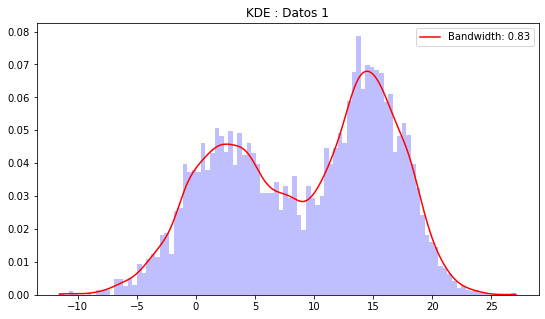

In [5]:
np.random.seed(150)
data1a_min, data1a_max = data1a.min(), data1a.max() #Límites de nuestros datos
xgrid1 = np.arange(data1a_min, data1a_max, 0.01) #Valores espaciados uniformemente en el intervalo
f_data1 = kde(data1a, np.linspace(0.01, 1, 30), 20, xgrid1, "KDE : Datos 1", color = ["red", "blue"]); #función kde
f_data1(xgrid1) #Dist de prob. sobre x de muestra de data1
#f_data1(xgrid1).shape

+ El **bandwidth óptimo** ajustado a la muestra de datos de la columna 1 es de **.83** y la **distribución de probabilidad** se comporta de la sig. manera.

Utilizar el método de **aceptación y rechazo** para generar **100 muestras aleatorias**, implementando los **tres métodos de reducción de varianza** vistos en clase.

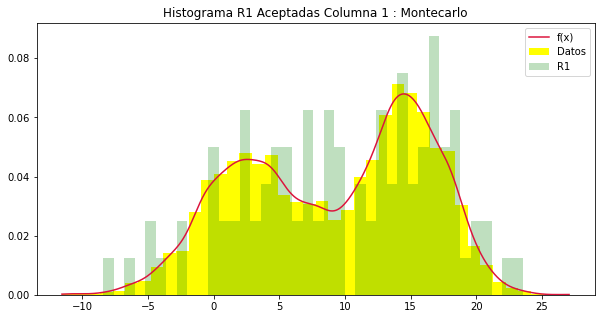

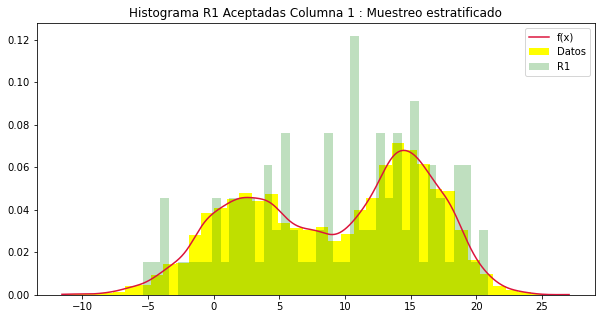

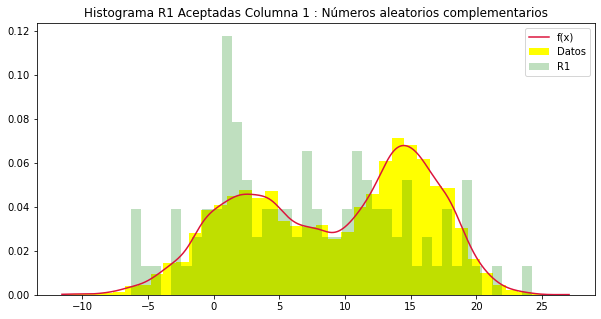

In [6]:
N=100 #Muestras Aleatorias
t1 = f_max(f_data1) #Máximo de f(x)
methods = ["Montecarlo", "Muestreo estratificado", "Números aleatorios complementarios"] #Métodos de reducción de varianza
x_accepted1 = [acceptanceRejection(f_data1, t1, [data1a_min, data1a_max], N, method) for method in methods] 
#Variables aleatorias aceptadas en el intervalo de f(x) de 100 muestras aleatorias.

#Histograma de aceptación rechazo con los 3 métodos de reducción de varianza
[acceptanceRejectionPlot(data1a, x_accepted1[i], 40, f_data1, xgrid1, "Histograma R1 Aceptadas Columna 1 : " + method, 
 (10, 5), ["crimson","yellow", "g"]) for i, method in zip(range(len(x_accepted1)), methods)];

In [7]:
np.random.seed(551)
AR_Montecarlo= acceptanceRejection(f_data1, t1, [data1a_min, data1a_max], 100, 'Montecarlo')
AR_Estratificado= acceptanceRejection(f_data1, t1, [data1a_min, data1a_max], 100, 'Muestreo Estratificado')
AR_Complementarios= acceptanceRejection(f_data1, t1, [data1a_min, data1a_max], 100, 'Números aleatorios complementarios')
print('Al realizar el método de aceptación y rechazo para generar 100 muestras aleatorias se obtiene que el valor esperado\
 para los tres métodos de reducción de varianza son los siguientes:') 

print('Montecarlo:', np.array(AR_Montecarlo).mean().round(4))
print('Muestreo Estratificado:',np.array(AR_Estratificado).mean().round(4))   
print('Números Complementarios:',np.array(AR_Complementarios).mean().round(4))  
print('Mientras que el valor esperado de los datos reales es:', data1a.mean().round(4))

Al realizar el método de aceptación y rechazo para generar 100 muestras aleatorias se obtiene que el valor esperado para los tres métodos de reducción de varianza son los siguientes:
Montecarlo: 10.3715
Muestreo Estratificado: 9.4709
Números Complementarios: 7.5601
Mientras que el valor esperado de los datos reales es: 9.1846


Se concluye que el método de reducción de varianza más acertado para el ejercicio anterior con 100 muestras es el de **Muestreo Estratificado** porque su valor esperado se acerca más a los datos reales.

b). **Para el conjunto de datos 2 y 3** de su archivo `Datos_a.csv` (columnas 2 y 3 de el correspondiente DataFrame), usando el método de **quantil-quantil (Q-Q)**, determine la distribución de probabilidad de dicho conjunto de datos.(**Ayuda**: Optimicen la función que desarrollamos en clase para probar que una PDF se ajusta a un conjunto de datos la cuál usa el paquete estadístico, para que encuentren cual es la **distribución de probabilidad más probable** y puedan utilizar el método de Q-Q.)

In [8]:
#Muestra de la población de datos de columna 2 y 3
np.random.seed(501) #Semilla para fijar valores aleatorios
data2b = np.random.choice(data.iloc[:,1],5000)
data3b = np.random.choice(data.iloc[:,2],5000)
data2b, data3b

(array([23.43419951, 20.84586114, 23.91193606, ..., 16.4003605 ,
        13.5219749 , 21.24954794]),
 array([ 7.86443324, 11.60027519,  6.91233143, ..., 12.19256144,
         8.20172778,  6.97665148]))

+ Para eficientar, se toma una muestra aleatoria de 5,000 datos de la población para la columna 2 y 3 puesto que contienen 100,000 datos cada uno.

(                MSE
 gausshyper  0.00006
 johnsonsb   0.00006,
                MSE
 nakagami  0.000012
 chi       0.000012)

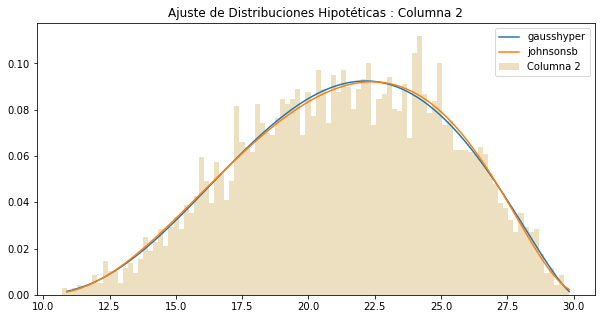

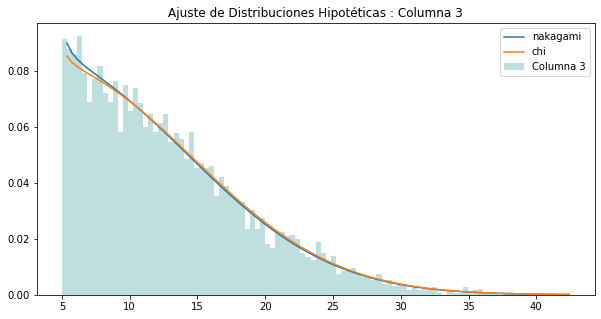

In [9]:
fitting_2b = fittingHypotheticalDistributions(data2b, "MSE", "Columna 2", "darkgoldenrod", 
                                            "Ajuste de Distribuciones Hipotéticas : Columna 2", (10, 5))
fitting_3b = fittingHypotheticalDistributions(data3b, "MSE", "Columna 3", "teal", 
                                            "Ajuste de Distribuciones Hipotéticas : Columna 3", (10, 5))
fitting_2b, fitting_3b 

+ Se obtienen las 2 distribuciones continuas que mejor ajustan a los datos (de entre las 101 disponibles en el paquete estadístico) las cuales poseen ambas un **error cuadrático medio** de **.00006** para el **2° conjunto de datos** y de **.000012** para el **3° conjunto**. Se verifica posteriormente mediante la prueba de hipótesis si se rechaza el hecho de que dichas distribuciones puedan estimar los datos con la prueba visual de quantil-quantil y con la prueba de la chi cuadrada en el inciso d).

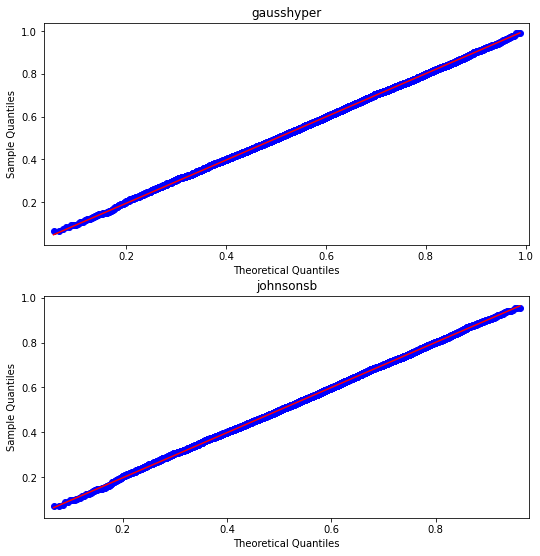

In [11]:
qqPlot(data2b, fitting_2b, (8, 8))

+ Según la prueba visual del gráfico quantil-quantil sobre el **2° conjunto de datos**, las distribuciones gausshyper y johnsonsb son aquellas que mejor modelan su distribución porque su **error cuadrático medio** es tan sólo de **.0006** y las estimaciones que de ellas provienen son iguales a las de los datos, es decir, que **y=x**. Esto puede apreciarse en la inclinación de **45°** en las líneas del gráfico porque su pendiente es unitaria. Se optará por trabajar con la dist. de **gausshyper** para el conjunto de datos 2.

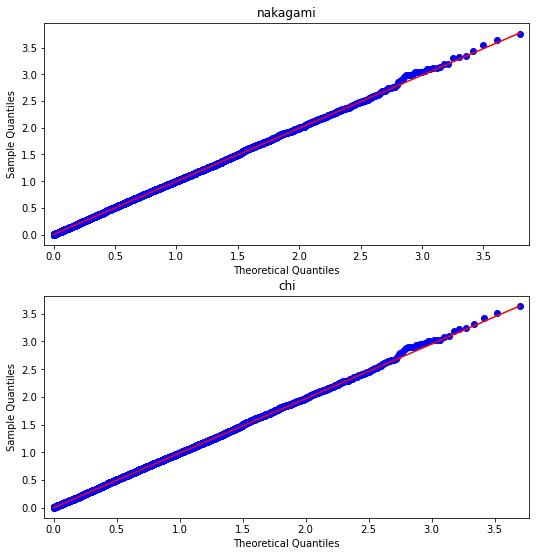

In [12]:
qqPlot(data3b, fitting_3b, (8, 8))

+ Para el **3° conjunto de datos**, se observa mediante la prueba visual de quantil-quantil que las distribuciones de probabilidad de nakagami y chi **concuerdan con la línea a 45°** a excepción de una ligera desviación en ambas colas derechas pero su **error cuadrático medio** es mínimo y equivalente: **.000012** . Se optará por trabajar con la dist. **chi** para el conjunto de datos 3 y como la prueba visual no es suficiente se procederá a realizar la prueba de la chi cuadrada en el inciso d).

c). Según los resultados concluidos con el método quantil-quantil y la prueba de hipótesis, implemente el **método de máxima verosimilitud** en python, para estimar los parámetros `loc` y `scale` de las dos distribuciones de probabilidad ajustadas. **Compare los resultados usando el histograma** de los datos, (use **bins=60)** y su respectiva función de densidad ajustada. Los resultados esperados para cada distribución se deben de reportar como sigue: 
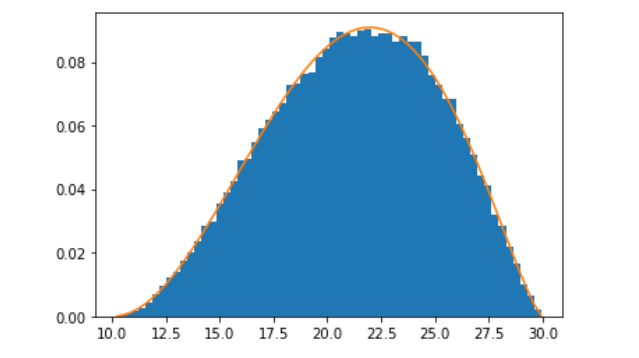

In [13]:
#Ajuste de distribución de probabilidad seleccionada a nuestros datos (columna 2).
params_2b= st.gausshyper.fit(data2b) #Obtención de parámetros de la distribución ajustada.
#Separación de las partes de los parámetros.
arg_2b = params_2b[:-2] #Argumentos de la distribución de probabilidad, gausshyper posee los argumentos (a,b,c,z).
loc_2b = params_2b[-2] #Loc hace referencia a la media de la distribución, cuyo valor sería 0 si se tratase de una dist. normal.
scale_2b = params_2b[-1] #scale se refiere a la desv. std. de la distribución, cuyo valor sería 1 si se tratase de una normal.
params_2b #Obtención de parámetros

(3.809227738978077,
 2.3941068343674434,
 1.3485950687222603,
 1.08619769665738,
 9.357367497681388,
 20.658016058958523)

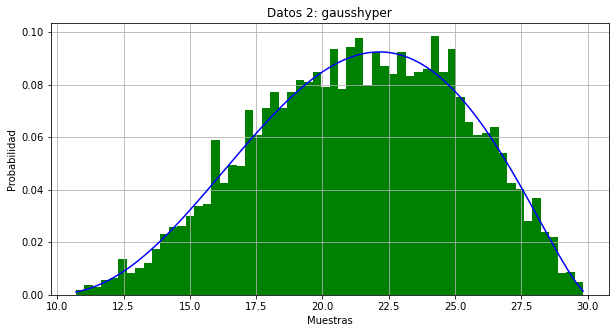

Los parametros son= loc: 9.36 , scale: 20.66 y los argumentos: (3.809227738978077, 2.3941068343674434, 1.3485950687222603, 1.08619769665738)


In [14]:
data2b_min, data2b_max = data2b.min(), data2b.max() #Límites de la 2° columna de datos.
xgrid2b = np.arange(data2b_min, data2b_max, 0.01) #Valores espaciados uniformemente en el intervalo.
y2b=st.gausshyper.pdf(xgrid2b, a= params_2b[0], b= params_2b[1], c= params_2b[2], z= params_2b[3], loc=loc_2b, scale=scale_2b)
#Creación de pdf con los parámetros obtenidos para la distribución gausshyper sobre los datos en cuestión (2° columna)

#Gráfico
plt.figure(figsize = (10,5))
plt.grid()
plt.plot(xgrid2b,y2b,'b-')
plt.hist(data2b,bins=60, density=True, color='g')
plt.title('Datos 2: gausshyper')
plt.xlabel('Muestras')
plt.ylabel('Probabilidad')
plt.show()

print('Los parametros son= loc:',loc_2b.round(2),', scale:', scale_2b.round(2), 'y los argumentos:', arg_2b)

Los parámetros de la distribución **gausshyper** ajustada a la muestra del conjunto de datos contenido en la columna 2 `loc: 9.36` y `scale: 20.66` y sus argumentos.
+ a= 3.81
+ b= 2.39
+ c= 1.35
+ z= 1.09

In [15]:
#Ajuste de distribución de probabilidad seleccionada a nuestros datos (columna 3).
params_3b= st.chi.fit(data3b) #Obtención de los parámetros para la dist. gonpertz ajustada
#Separación de las partes de los parámetros.
arg_3b = params_3b[:-2] #Argumento de la distribución de probabilidad, gompertz posee el argumento (c).
loc_3b = params_3b[-2] #Loc hace referencia a la media de la distribución en penúltimo lugar de los parámetros
scale_3b = params_3b[-1] #scale se refiere a la desv. std. de la distribución, en últ. lugar de los parám.
params_3b #Obtención de parámetros

(0.9642992535808987, 5.000258709635572, 10.284677051257109)

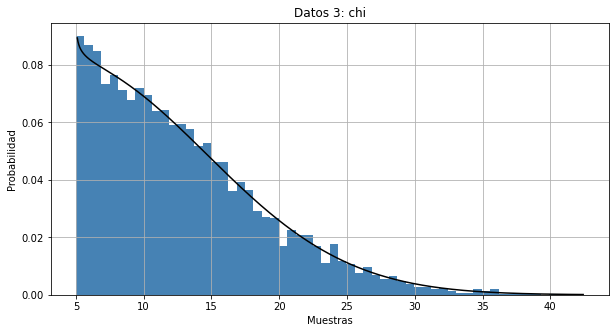

Los parametros son= loc: 5.0 , scale: 10.28 y el argumento: (0.9642992535808987,)


In [16]:
np.random.seed(152)
data3b_min, data3b_max = data3b.min(), data3b.max() #Lím. de la muestra de la 3° columna de datos.
xgrid3b = np.arange(data3b_min+.10, data3b_max, 0.01) #Valores espaciados uniformemente en el intervalo.
y3b=st.chi.pdf(xgrid3b,df= arg_3b, loc=loc_3b, scale=scale_3b)
#Creación de pdf con los parámetros obtenidos para la distribución gausshyper sobre los datos en cuestión (2° columna)

#Gráfico
plt.figure(figsize = (10,5))
plt.grid()
plt.plot(xgrid3b,y3b,'k-')
plt.hist(data3b,bins=60, density=True, color='steelblue')
plt.title('Datos 3: chi')
plt.xlabel('Muestras')
plt.ylabel('Probabilidad')
plt.show()

print('Los parametros son= loc:',loc_3b.round(2),', scale:', scale_3b.round(2), 'y el argumento:', arg_3b)

Los parámetros de la distribución **chi** ajustada a la muestra del conjunto de datos contenido en la columna 3 son `loc: 5`, `scale: 10.28` y su argumento df= .96

d). Use la prueba chi cuadrado - Usando el histograma (como se vió en clase), y los resultados del literal c) y responda la siguiente prueba de hipótesis para cada distribución:
> $H_0$: la distribución es `distribución_i` con ´paramétro 1 = p1´ y ´parámetro 2 = p2 ´

> $H_a$: los datos no se distribuyen como `distribución_i`

Observe que `paramétro 1` y `paramétro 2` dependerán de cada una de las distribuciones seleccionadas, por ejemolo si la `distribución_i` fuera normal entonces  `paramétro 1` y `paramétro 2` serían la media $\mu$ y desviación estándar $\sigma$, respectivamente.**Nota:** Recuerde que el método de máxima verosimilitud puede estimar `loc` y `scale` únicamente o `loc` y `scale` y otros parámetros de la distribución a ajustar (ver por ejemplo clase 19, la explicación del uso del método fit, para aclarar). Concluya, usando los resultados arrojados por su prueba de hipótesis.

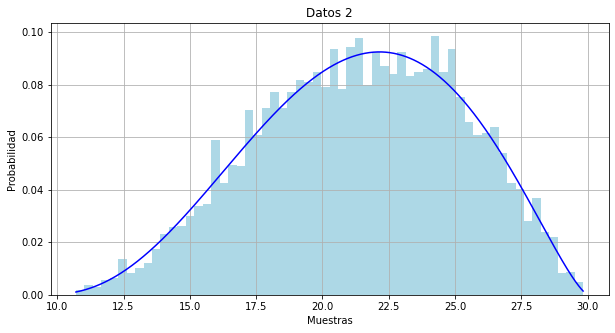

In [17]:
np.random.seed(552) #semilla para fijar valores
# Parámetros reales de la PDF
mu_real = loc_2b; sigma_real = scale_2b #media y desv. std.
N = len(data2b) #Cantidad de muestras
n1 = data2b #Conjunto de datos
J = 60  # Cantidad de particiones del histograma, es decir los bins.
#Gráfico y estética
plt.figure(figsize = (10,5))
plt.grid()
[y2b_d, x, a] = plt.hist(n1, J, density=True, color='lightblue')
plt.plot(xgrid2b,y2b,'b-')
plt.title('Datos 2')
plt.xlabel('Muestras')
plt.ylabel('Probabilidad')
plt.show()
# Se obvia el último valor de x para obtener exactamente J muestras de x
x = x[:-1]

In [18]:
pi = st.gausshyper.pdf(x,a= 3.81, b= 2.39, c= 1.35, z= 1.09, loc= 9.36, scale= 20.66) #pdf con sus parámetros evaluada en x
Ei = x*pi # Cálculo de la esperanza usando la expresión teórica
x2 = np.sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y2b_d))) # Cálculo teórico de la chi cuadrada
print('Valor de chi cuadrada teorica  = ', x2) 
X2 = st.chisquare(y2b_d, Ei) # Cálculo usando la librería estadística de la chi cuadrada
print('Valor de chi cuadrado librería = ', X2)
p = 6 # Parámetros estimados con los datos
m = J-p-1 # grados de libertad
Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
mu,sigma = np.mean(x), np.std(x)
print('media mu = %f, desviación estándar muestral = %f'%(mu,sigma))

Valor de chi cuadrada teorica  =  61.0209546623162
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=61.0209546623162, pvalue=0.40314714208383784)
Estadístico de chi_cuadrado =  70.99345283378227
media mu = 20.108889, desviación estándar muestral = 5.519748


$H_0$: La mejor distribución de probabilidad para el **2° conjunto** de datos es `gausshyper` con sus parámetros de `a=3.81, b=2.39, c= 1.35 , z=1.09, loc=9.36 y scale=20.66`. Como su **pvalue es .40** y mayor a .05 (valor de significancia) **no se rechaza la hipótesis** de que se puede utilizar la distribucion de gausshyper para estimar los datos contenidos en la columna 2.

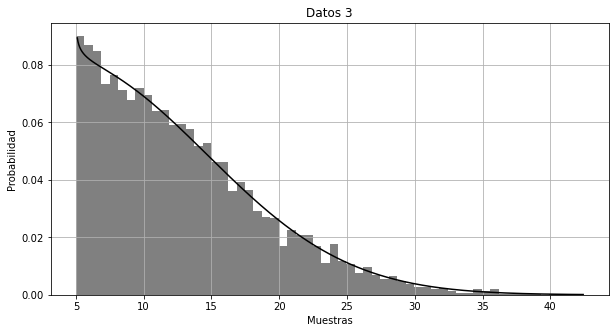

In [19]:
np.random.seed(555) #semilla para fijar valores
# Parámetros reales de la PDF
mu_real_3, sigma_real_3 = loc_3b, scale_3b #media y desv. std.
N3 = len(data3b) #Cantidad de muestras
n3 = data3b #Conjunto de datos
J = 60  # Cantidad de particiones del histograma, es decir los bins.
#Gráfico y estética
plt.figure(figsize = (10,5))
plt.grid()
[y3b_d, x_3, a_3] = plt.hist(n3, J, density=True, color='gray')
plt.plot(xgrid3b,y3b,'k-')
plt.title('Datos 3')
plt.xlabel('Muestras')
plt.ylabel('Probabilidad')
plt.show()
# Se obvia el último valor de x para obtener exactamente J muestras de x
x_3 = x_3[:-1] 

In [20]:
pi_3 = st.chi.pdf(x_3, df=.96, loc=5, scale=10.28) #pdf con sus parámetros evaluada en x
Ei_3 = x_3*pi_3 #Caculo de la esperanza usando la expresión teórica
x2_3 = np.sum(list(map(lambda Ei_3, obs_i_3:(obs_i_3 - Ei_3)**2 / Ei_3, Ei_3, y3b_d))) # Cálculo teórico de la chi cuadrada
print('Valor de chi cuadrada teorica  = ', x2_3) 
X2_3 = st.chisquare(y3b_d, Ei_3) # Cálculo usando la librería estadística de la chi cuadrada
print('Valor de chi cuadrado librería = ', X2_3)
p_3 = 3 # Parámetros estimados con los datos
m_3 = J-p_3-1 # grados de libertad
Chi_est_3 = st.chi2.ppf(q=0.95, df=m_3)
print('Estadístico de chi_cuadrado = ', Chi_est_3)
mu_3,sigma_3 = np.mean(x_3), np.std(x_3)
print('media mu =%f, desviación estándar muestral =%f'%(mu_3,sigma_3))

Valor de chi cuadrada teorica  =  18.069766239426766
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=18.069766239426766, pvalue=0.9999999446785811)
Estadístico de chi_cuadrado =  74.46832415930936
media mu =23.399507, desviación estándar muestral =10.801358


$H_0$: La mejor distribución de probabilidad para el **3° conjunto** de datos es `chi` con sus parámetros de `df=.96, loc=5 y scale=10.28`. Como su **pvalue es .99** y es mayor a .05 (valor de significancia) **no se rechaza la hipótesis** de que se puede utilizar la distribucion de chi para estimar los datos contenidos en la columna 3.

# 2 
Considere la siguiente función de distribución de probabilidad

$$X\sim binomial(n,p) \longrightarrow p_k=P(X=k) =\frac{5\,!}{k\,!(5-k)\,!}0.7^k\big(1-0.7\big)^{5-k}$$
> Por propiedades de la operación factorial la anterior $p_k$ se puede escribir como:
> $$p_{k+1}=\frac{5-i}{k+1}\frac{.7}{1-.7} p_k $$



a). Utilice el método de la **transformada inversa**  para generar **1000 muestras aleatorias** que distribuyan según la distribución $p_k$. Grafique el histograma de dichas muestras aleatorias obtenidas y a su vez la función de densidad $p_k(x)$, para validar los resultados obtenidos. **Sugerencia**: Revise los ejercicios realizados en la clase 15. Los resultados esperados son como se muestran en la siguiente gráfica:
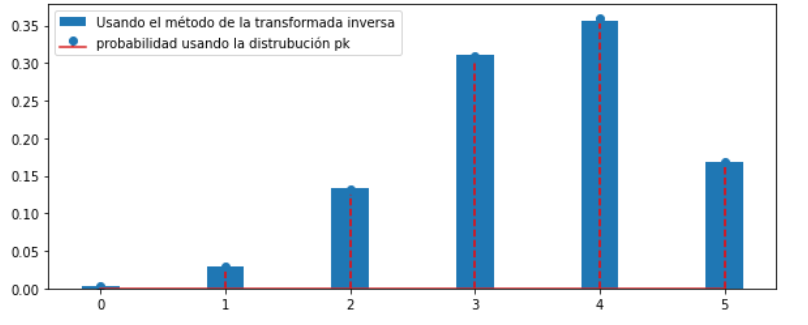

<font color ='red'>  **Nota**: Recuerde que $p_k$ es una distribución de probabilidad discreta así que los histogramas realizados deben ser discretos y no continuos. Utilice el método desarrollado en clase para reportar adecuadamente el historgrama </font>

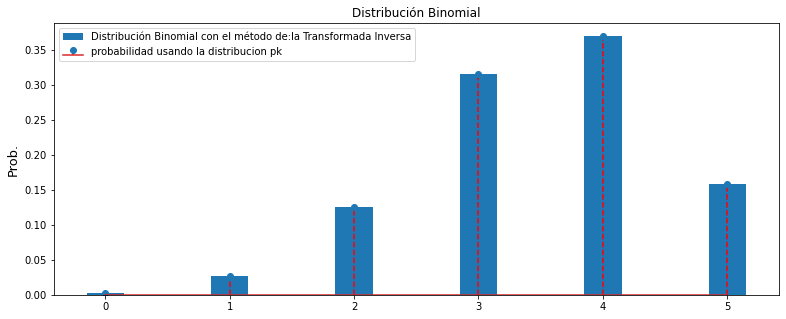

Las probabilidades para cada número: [0 1 2 3 4 5] son: [0.002 0.027 0.126 0.316 0.37  0.159] respectivamente. Se comprueba la suma de sus probabilidades igual a = 1.0


In [21]:
np.random.seed(610)
def inversa(n: 'n. binom.',p:'p. binom.',N:'Muestras'):
    '''
    Función binomial generada a partir de una distribución uniforme mediante el uso de
    la fórmula: ((p/(1-p))*(n-i)/(i+1))*pi. .
    '''
    def acum():
        pi = np.zeros(n) #Creación de vector para su llenado
        pi[0] = (1-p)**n #Primer posición
        def p_n(i): #Llenado de posiciones restantes
            nonlocal pi #Trabajo con variable no local
            pi[i+1]=((p/(1-p))*(n-i)/(i+1))*pi[i] #Iteraciones de llenado a partir de fórmula de dist. binomial
        [p_n(i) for i in range(n-1)] #Compresión de listas
        return pi.cumsum() #Suma acumulada
    p_cum = acum() #Llamado de función acum.
    u = np.random.rand(N) #Valores aleatorios 
    inv = np.array(list(map(lambda z:sum(1 for i in p_cum if i<u[z]),range(N))))
    return inv

def histograma_discreto(dist:'Gráfica', title : "Título del gráfico", n:'Parámetro n de la dist. binomial', M: 'Método'):
    '''
    Función para graficar el histograma de la función discreta generada. Recibe dos variables: dist, que es la distribución 
    generada de forma discreta, y nombre, que es la etiqueta de la gráfica.
    '''
    #x= de 0 a n+1 por ser excluyente, con paso 1 por ser discreto. y= son las contabilizaciones de sucesos en inversa.
    plt.bar(np.arange(0,n+1,1), np.bincount(dist)/N,label='Distribución Binomial con el método de:'+str(M), width=.3)
    #Líneas verticales de la prob o y para cada x
    plt.stem(np.arange(0,n+1,1), np.bincount(dist)/N, '--r', label= 'probabilidad usando la distribucion pk') 
    plt.title(title)
    plt.legend()
    plt.show() 
    
#Parametros de la distribución    
n = 5
p = 0.7
N = 1000 #Muestras aleatorias

inv = inversa(n,p,N) #Transformada inversa con los parámetros de la distribución.

#Gráfico
plt.figure(figsize = (13, 5)) #Tamaño y label de 'y'
plt.ylabel('Prob.', fontsize= 13)
histograma_discreto(inv,'Distribución Binomial', n, 'la Transformada Inversa') #Hist. del método de la transformada inversa para la dist. binom. c/ stem.

#Probabilidades de cada número (0,1,2,3,4,5)
print('Las probabilidades para cada número:',np.arange(0,n+1,1),'son:',np.bincount(inv)/N,'respectivamente. \
Se comprueba la suma de sus probabilidades igual a =',(np.bincount(inv)/N).sum()) #Parámetro y (probabilidad)

Se grafica la distribución binomial con los parametros n=5 y p=0.7 con el método de la transformada inversa y se obtiene el valor de la probabilidad obtenida para cada numero mediante un diagrama de tallo vertical.
Se obtiene que la probabilidad de ocurrencia es de:
+ **0**: .2%
+ **1**: 2.7%
+ **2**: 12.6%
+ **3**: 31.6%
+ **4**: 37%
+ **5**: 15.9%


b). Repita el inciso anterior pero en esta ocasión utilice el método de aceptación y rechazo para generar las muestras aleatorias. 

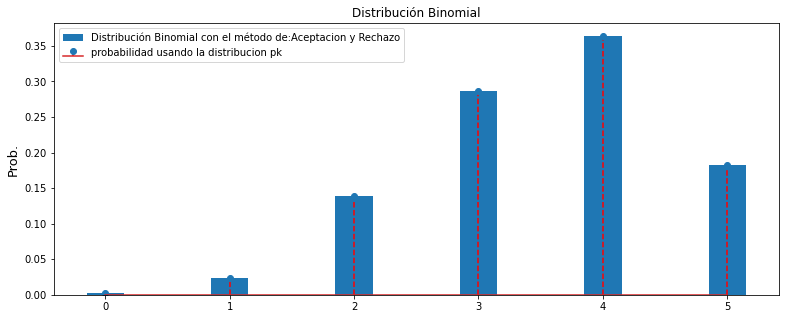

La ocurrencia para cada número es: {0: 3, 1: 24, 2: 139, 3: 287, 4: 364, 5: 183} con 1000 muestras. Se comprueba la suma de sus probabilidades igual a= 1.0


In [22]:
np.random.seed(613)
def Acceptance_Rejection(f : "Función objetivo", t : "Max. de f(x)",  x: "Datos sobre x expreso como un array", 
                        N : "Variables aleatorias generadas "):
    
    X=np.zeros(N) #Creación de vector con 0s para su llenado
    i= 0 #Iteración comenzada en 0
    while i<N:
        R1 = np.random.randint(x[0], x[-1]+1)
        R2 = np.random.uniform(0,t)
        if R2<= f(R1):
            X[i] = R1
            i+=1
    return X


#función de distribución de probabilidad binomial
f= lambda x: (np.math.factorial(n)/(np.math.factorial(x)*(np.math.factorial(n-x)))*(p**x)*(1-p)**(n-x))
#x= de 0 a n+1 por ser excluyente, con paso 1 por ser discreto.
x= np.arange(0,n+1,1)
N=1000 #Muestras
#Aceptación y rechazo como entero (discreto)
Acep_R=Acceptance_Rejection(f, 1, x, N).astype(int)
#Contabilización de ocurrencias y promedio
unique, counts = np.unique(Acep_R, return_counts=True)
dict(zip(unique, counts)), (counts.sum())/N

#Gráfico
plt.figure(figsize = (13,5)) #Tamaño y label de 'y'
plt.ylabel('Prob.', fontsize= 13)
#Hist. del método de Aceptacion y Rechazo para la dist. binom. c/ stem.
histograma_discreto(Acep_R,'Distribución Binomial', n, 'Aceptacion y Rechazo') 

#Probabilidades de cada número (0,1,2,3,4,5)
print('La ocurrencia para cada número es:',dict(zip(unique, counts)),'con',N,'muestras. Se comprueba la suma de sus probabilidades\
 igual a=',(counts.sum())/N) #Parámetro y (probabilidad))

En conclusion, se obtienen resultados con probabilidades ligeramente distintas por la generación de muestras aleatorias que no son siempre las mismas, sin embargo, los resultados demuestran ser certeros cuando se comprueba la suma de sus probabilidades igual a 1.

# 3 
Richard Collins, gerente y propietario de Richard's Tire Service, desea utilizar simulación para analizar el funcionamiento de su taller. Una de las actividades que se incluirán en la simulación es la instalación de neumáticos de automóvil (incluido el equilibrado de neumáticos). Richard estima que la función de distribución acumulada (CDF) de la distribución de probabilidad del tiempo (en minutos) requerido para instalar un neumático tiene el gráfico que se muestra a continuación.
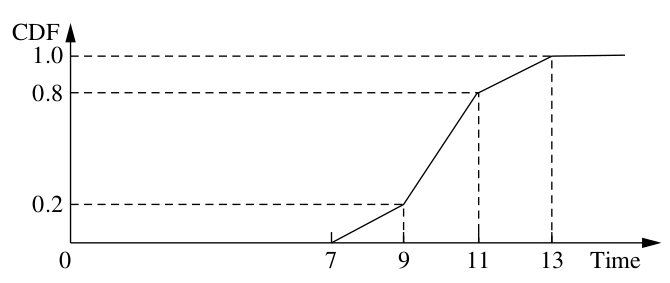

a). Dibuje la densidad de probabilidad de la distribución de la gráfica $f(x)$.

b). Para realizar una comparación, realice el desarrollo analítico del valor esperado.

c). Realice el desarrollo teórico (markdown) para obtener muestras aletorias de esta dstribución usando el método de la función inversa. Con los resultados obtenidos, genere 1000 muestras y  grafique el histograma de dichas muestras aleatorias obtenidas y a su vez la función de densidad f(x), para validar los resultados obtenidos.

d). Use el método de aceptación y rechazo para generar 1000 muestras aleatorias (no confundir con la gŕafica de los puntos aceptados) y grafique el histograma de dichas muestras aleatorias obtenidas y a su vez la función de densidad f(x), para validar los resultados obtenidos.

**Se desea estimar la media de esta distribución, usando el método montecarlo crudo y sus técnicas de reducción de varianza con muestras de tamaño 10,100 y 1000. Estas cantidades de muestras para cada uno de los siguientes literales:** 

e).Use el método de montecarlo crudo para estimar la media.

f). Use el método de muestreo estratificado con 5 estratos $0\leq F(x)\leq0.3, 0.3\leq F(x)\leq0.5, 0.5\leq F(x)\leq0.7, 0.7\leq F(x)\leq0.9 $ y $0.9\leq F(x) \leq 1$. Reparta el total de muestras en los estratos de la siguiente forma: estrato 1, 2, 3, 4, 5, 20%,20%,25%,15% y 20% de las muestras respectivamente.

g). Use el método de los números complementarios para estimar la media.

h). Finalmente use el método de estratificación en el cúal se divide en N estratos.

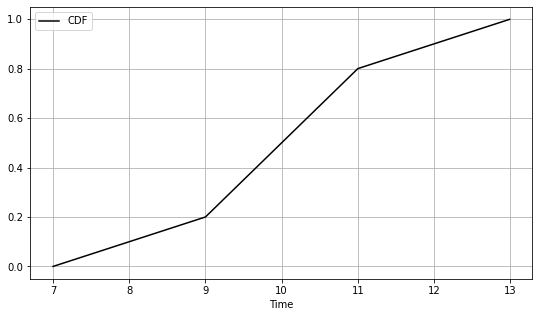

In [23]:
#CDF generación de datos..
x_1=np.arange(7,9,.01)
x_2=np.arange(9,11,.01)
x_3=np.arange(11,13,.01)
#Obtencion de ecs.: ec1. punto pendiente y ec. 2 puntos
Y_1= 0.1 * x_1 - 0.7
Y_2= 0.3 * x_2 - 2.5
Y_3= 0.1 * x_3 - .30
#Se reduce a una ec.
x=np.concatenate((x_1,x_2,x_3))
Y=np.concatenate((Y_1,Y_2,Y_3))
#Gráfico de cdf
plt.figure(figsize = (9,5))
plt.plot(x,Y, label='CDF', c='k')
plt.xlabel('Time')
plt.grid()
plt.legend()

Una forma de obtener la CDF es a través de la ecuación de punto pendiente y la ecuación de la recta que pasa por dos puntos para los intervalos planteados donde se puede suponer que la distribución de probabilidad es discreta por el cambio de sus pendientes únicamente sobre valores enteros para X. También existe el argumento de que las unidades de tiempo tienen valores intermedios sobre sus valores enteros por lo cual también se podría considerar una distribución de probabilidad continua. 

### a) PDF

Se puede obtener la PDF de distintas maneras, una opción es a través de la derivada de CDF:

$$\frac{\ dF(x)}{\ dx}  = f(x) $$


$$ F(x)=\begin{cases}{.1x-0.7},& \text{en }7 \leq x\leq 9 \\ {.3x-2.5},& \text{en }9 \leq x\leq 11 \\ {.1x-0.3},& \text{en }11 \leq x\leq 13 \\\end{cases}$$

Si $\frac{\ dF(x)}{\ dx}  = f(x) $ entonces:

$$f_1= \frac{\ d}{\ dx} {(.1x-0.7)} = 0.1 $$
$$f_2= \frac{\ d}{\ dx} {(.3x-2.5)} = 0.3 $$
$$f_3= \frac{\ d}{\ dx} {(.1x-0.3)} = 0.1 $$

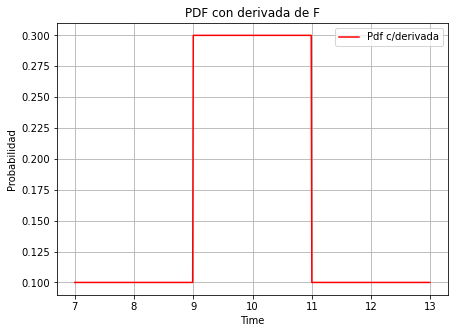

In [24]:
#Derivada
y_1=np.ones(len(x_1))*0.1
y_2=np.ones(len(x_2))*0.3
y_3=np.ones(len(x_3))*0.1
y=np.concatenate((y_1,y_2,y_3)) #shape de 600 por crear la ecuacion con step de .01 (200*x3)
#Gradiente
#Gráfico
plt.figure(figsize = (7,5))
plt.plot(x,y, color='r', label='Pdf c/derivada')
plt.title('PDF con derivada de F')
plt.xlabel('Time')
plt.ylabel('Probabilidad')
plt.grid()
plt.legend()

La pdf nos dice que el valor esperado o más probable está entre 9 y 11.

### b) Valor esperado

Para una variable aleatoria continua $X$ el valor esperado y la media $\mu$ son:
$$\mu= E(X)= \int_{\infty}^{\infty}{(x f_X(x))}dx$$

Por lo tanto
$$E(X)= \int_{7}^{9}{(0.1x)}dx + \int_{9}^{11}{(0.3x)}dx + \int_{11}^{13}{(0.1x)}dx$$
es igual a:
$$0.05x^{2}\bigg|_{7}^{9} + 0.15x^{2}\bigg|_{9}^{11} + 0.05x^{2}\bigg|_{11}^{13} = 1.6 + 6 + 2.4 = 10$$

Para obtener el valor esperado de una distribución discreta el valor esperado es: 
$$
\mathbb {E} [X]=x_{1}p(X=x_{1})+...+x_{n}p(X=x_{n})=\sum _{i=1}^{n}x_{i}p(x_{i})
$$

In [25]:
#Comprobación
print('La duración esperada para la instalación de neumáticos siguiendo una dist. continua es μ:',x.mean().round(1))

La duración esperada para la instalación de neumáticos siguiendo una dist. continua es μ: 10.0


In [26]:
tiempo = [7,8,9,10,11,12,13]
prob=[0,.1,.1,.3,.3,.1,.1]
prob_cum=[0,.1,.2,.5,.8,.9,1]


data = pd.DataFrame({'tiempo': tiempo,'probabilidad': prob,
                    'p_acumulada': prob_cum})
data.set_index('tiempo', inplace=True)
media_teo = (np.array(tiempo) * prob).sum()
data
print('La duración esperada para la instalación de neumáticos siguiendo una dist. discreta es\
 su media teórica =', media_teo)

La duración esperada para la instalación de neumáticos siguiendo una dist. discreta es su media teórica = 10.5


### c) Función Inversa

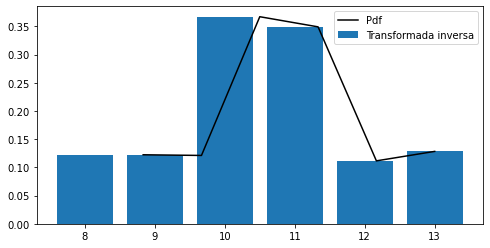

In [27]:
def Gen_distr_discreta(p_acum: 'P.Acumulada de la distribución a generar',
                       indices: 'valores reales a generar aleatoriamente',
                       U: 'Numeros aleatorios'):
    
    # Diccionario de valores aleatorios
    rand2reales = {i: idx for i, idx in enumerate(indices)}

    # Series de los valores aletorios
    y = pd.Series([sum([1 for p in p_acum if p < ui]) for ui in U]).map(rand2reales)

    return y

def plot_histogram_discrete(distribucion:'distribución a graficar histograma',
                            label:'label del legend'):
    plt.figure(figsize=[8,4])
    y,x = np.histogram(distribucion,density = True,bins = len(set(distribucion)))
    plt.plot(x[1:],y, color='k', label='Pdf')
    plt.bar(list(set(distribucion)),y,label=label)
    plt.legend()
    plt.show()

N = 1000
U =np.random.rand(N)
m1 = Gen_distr_discreta(data['p_acumulada'], tiempo, U)
plot_histogram_discrete(m1,'Transformada inversa')

Para el caso discreto se obtienen la siguiente distribución de probabilidad con la siguiente pdf.

### d) Aceptación y Rechazo

### e) Método de Montecarlo crudo

In [28]:
N = [10,100,1000]
N = np.array(N)
a = 7; b = 13
U= list(map(lambda x: np.random.randint(a,b+2,N),N))
monte_1 = U
[monte_1[i].sum()/len(N) for i in range(0,len(N))]

df_mu=pd.DataFrame(columns=["N=10","N=100","N=1000"],
                   index = ["Montecarlo","errorMc%","Muestreo Estratificado","errorE%","Complementarios",
                    "errorComp.%","N estratos","errorNEst%"])
df_mu.loc["Montecarlo"]=[monte_1[i].mean() for i in range(0,3)]
df_mu.loc["errorMc%"]=np.abs(df_mu.loc['Montecarlo']-(media_teo.mean()))*100/(media_teo.mean())
df_mu

,N=10,N=100,N=1000
Montecarlo,10.498997,10.501521,10.502422
errorMc%,0.009552,0.014486,0.023067
Muestreo Estratificado,NaN,NaN,NaN
errorE%,NaN,NaN,NaN
Complementarios,NaN,NaN,NaN
errorComp.%,NaN,NaN,NaN
N estratos,NaN,NaN,NaN
errorNEst%,NaN,NaN,NaN


### f) Muestreo Estratificado

f). Use el método de muestreo estratificado con 5 estratos $0\leq F(x)\leq0.3, 0.3\leq F(x)\leq0.5, 0.5\leq F(x)\leq0.7, 0.7\leq F(x)\leq0.9 $ y $0.9\leq F(x) \leq 1$. Reparta el total de muestras en los estratos de la siguiente forma: estrato 1, 2, 3, 4, 5, 20%,20%,25%,15% y 20% de las muestras respectivamente.3

In [29]:
def Gen_distr_discreta_red_var(prob_cum: 'P.Acumulada de la distribución a generar',
                       indices: 'valores reales a generar aleatoriamente',
                       U: 'Vector de n. aleatorios'):
    
    # Diccionario de valores aleatorios
    rand2reales = {i: idx for i, idx in enumerate(indices)}

    # Series de los valores aletorios
    y = pd.Series([sum([1 for p in prob_cum if p < ui]) for ui in U]).map(rand2reales)
    return y
e1 = np.random.uniform(0, 0.3, int(0.2*N[0]))
e2 = np.random.uniform(0.3, 0.5, int(0.2*N[0])) 
e3 = np.random.uniform(0.5, 0.7, int(0.25*N[0])) 
e4 = np.random.uniform(0.7, 0.9, int(0.15*N[0])) 
e5 = np.random.uniform(0.9, 1, int(0.2*N[0]))
e= [e1,e2,e3,e4,e5]
w=[(2/3),1,1.25, .75,2]
m2=list(map(lambda ui, wi: Gen_distr_discreta_red_var(prob_cum, tiempo, ui) /wi, e, w))
e2_10=np.concatenate(m2).mean()
df_mu.loc['Muestreo Estratificado']['N=10']=e2_10

e1_1 = np.random.uniform(0, 0.3, int(0.2*N[1]))
e2_1 = np.random.uniform(0.3, 0.5, int(0.2*N[1])) 
e3_1 = np.random.uniform(0.5, 0.7, int(0.25*N[1])) 
e4_1 = np.random.uniform(0.7, 0.9, int(0.15*N[1])) 
e5_1 = np.random.uniform(0.9, 1, int(0.2*N[1]))
e_1= [e1_1,e2_1,e3_1,e4_1,e5_1]
w_1=[(2/3),1,1.25, .75,2]
m2_1=list(map(lambda ui, wi: Gen_distr_discreta_red_var(prob_cum, tiempo, ui) /wi, e_1, w_1))
e2_100=np.concatenate(m2_1).mean()
df_mu.loc['Muestreo Estratificado']['N=100']=e2_100

e1_2 = np.random.uniform(0, 0.3, int(0.2*N[2]))
e2_2 = np.random.uniform(0.3, 0.5, int(0.2*N[2])) 
e3_2 = np.random.uniform(0.5, 0.7, int(0.25*N[2])) 
e4_2 = np.random.uniform(0.7, 0.9, int(0.15*N[2])) 
e5_2 = np.random.uniform(0.9, 1, int(0.2*N[2]))
e_2= [e1_2,e2_2,e3_2,e4_2,e5_2]
w_2=[(2/3),1,1.25, .75,2]
m2_2=list(map(lambda ui, wi: Gen_distr_discreta_red_var(prob_cum, tiempo, ui) /wi, e_2, w_2))
e2_1000=np.concatenate(m2_2).mean()
df_mu.loc['Muestreo Estratificado']['N=1000']=e2_1000

df_mu.loc['errorE%']=np.abs(df_mu.loc['Muestreo Estratificado']-(media_teo.mean()))*100/(x.mean())
df_mu
#Ojo: no se eficienta el código con un iterable que puede ser a través de una compresión de listas
#para e_i= [np.random.uniform(a, b, int(n*N[i])) for i in range(0,len(N))] por un error 
#no identificable por el usuario.

,N=10,N=100,N=1000
Montecarlo,10.498997,10.501521,10.502422
errorMc%,0.009552,0.014486,0.023067
Muestreo Estratificado,10.733333,10.48,10.4935
errorE%,2.334501,0.2001,0.065033
Complementarios,NaN,NaN,NaN
errorComp.%,NaN,NaN,NaN
N estratos,NaN,NaN,NaN
errorNEst%,NaN,NaN,NaN


### g) Números Complementarios

In [30]:
def Num_complementarios(N):
    U1= np.random.rand(N)
    U2= 1-U1
    U = np.concatenate([U1, U2])                  
    return U

u1_10 = np.random.rand(10)
u2_10 = 1 - u1_10
m4_10 = Gen_distr_discreta(prob_cum, tiempo, np.concatenate([u1_10, u2_10])).mean()
print('Complementario =',np.mean(m4_10))
df_mu.loc['Complementarios']['N=10']=m4_10

u1_100 = np.random.rand(100)
u2_100 = 1 - u1_100
m4_100 = Gen_distr_discreta(prob_cum, tiempo, np.concatenate([u1_100, u2_100])).mean()
print('Complementario =',np.mean(m4_100))
df_mu.loc['Complementarios']['N=100']=m4_100

u1_1000 = np.random.rand(1000)
u2_1000 = 1 - u1_1000
m4_1000 = Gen_distr_discreta(prob_cum, tiempo, np.concatenate([u1_1000, u2_1000])).mean()
print('Complementario =',np.mean(m4_1000))
df_mu.loc['Complementarios']['N=1000']=m4_1000

df_mu.loc['errorComp.%']=np.abs(df_mu.loc['Complementarios']-(media_teo.mean()))*100/(media_teo.mean())
df_mu

Complementario = 10.5
Complementario = 10.5
Complementario = 10.5


,N=10,N=100,N=1000
Montecarlo,10.498997,10.501521,10.502422
errorMc%,0.009552,0.014486,0.023067
Muestreo Estratificado,10.733333,10.48,10.4935
errorE%,2.334501,0.2001,0.065033
Complementarios,10.5,10.5,10.5
errorComp.%,0.0,0.0,0.0
N estratos,NaN,NaN,NaN
errorNEst%,NaN,NaN,NaN


#### h) N estratos

In [35]:
def estra_igualmente_espaciado(N):
    """
    Función que recibe el número de estratos y retorna un conjunto de variables aleatorias\
    donde todos los estratos se encuentran igualmente espaciados.
    """
    U = np.random.rand(N)
    i = np.arange(0, N)
    v = (U + i) / N
    return v

N = [10,100,1000]

U= [estra_igualmente_espaciado(i)for i in N]
estra2 = [Gen_distr_discreta(prob_cum, tiempo, i) for i in U]


df_mu.loc["N estratos"]=[estra2[i].mean() for i in range(0,len(N))]
df_mu.loc["errorNEst%"]=np.abs(df_mu.loc['N estratos']-(media_teo.mean()))*100/(media_teo.mean())

i). Compare todos los resulados obtenidos con cada método en una tabla unsando la librería pandas, donde muestre segun la cantidad de términos usados, la aproximación de la media aproximada y su error relativo con el valor obtenido en el inciso a). Se espera un resultado como el mostrado a continuación:
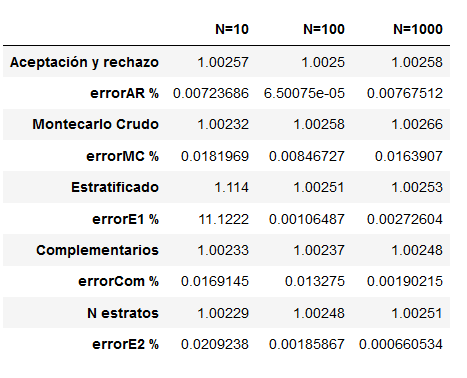

In [36]:
df_mu

,N=10,N=100,N=1000
Montecarlo,10.498997,10.501521,10.502422
errorMc%,0.009552,0.014486,0.023067
Muestreo Estratificado,10.733333,10.48,10.4935
errorE%,2.334501,0.2001,0.065033
Complementarios,10.5,10.5,10.5
errorComp.%,0.0,0.0,0.0
N estratos,10.5,10.5,10.5
errorNEst%,0.0,0.0,0.0


Con base a los resultados podemos concluir que los métodos más eficientes para este caso donde la media se supone discreta se obtienen a través del Método de Números Complementarios y N Estratos donde N=10 basta para la convergencia exacta al valor esperado teórico definido por: $$\mathbb {E} [X]=x_{1}p(X=x_{1})+...+x_{n}p(X=x_{n})=\sum _{i=1}^{n}x_{i}p(x_{i})$$ También se identifica la cuasi-convergencia del método de MonteCarlo para N=1000, lo cual implica una ineficiencia de cálculo más de 100 veces más lenta que los anteriores métodos para el caso planteado.

# 4
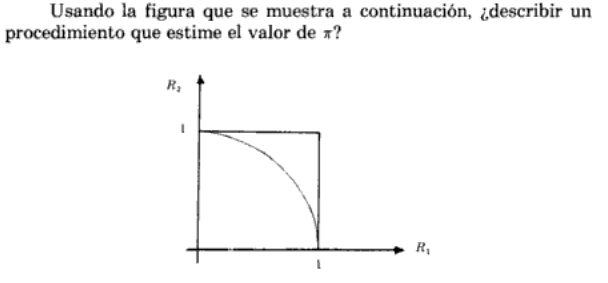

## <font color = 'red'> Nota: </font> Use el método de integración montecarlo visto en clase, exprese el área bajo la curva como una integral. Reporte todos sus cálculos teóricos usando markdown
    
a). Use el método de montecarlo para aproximar el **valor de pi**, es decir (3.1416...) para muestras de tamaño 100,1000,10000,1000000 y comparelo con su valor real. 



Sabemos que el área de un círculo es igual a: $$\text{A}_C= \pi r^{2} ∴ \pi = \frac{{A}_C}{r^{2}}$$

Si el radio fuera igual a 1, obtendriamos la siguiente expresion: $$\pi = \text{A}_C$$

Por lo tanto, podemos recurrir a la ecuación del círculo:

$x^{2}+y^{2} = r^{2}$ que en el caso de $r^{2} = 1$. Se convierte en: $$x^{2}+y^{2} = 1$$

Si despejamos para y obtenemos que $$y =  \sqrt{(1-x^2)}$$ Para dicha expresión tomamos el valor positivo de la raíz, es decir, la parte superior del círculo. 

Entonces, si consideramos la integral de $\frac{1}{4}$ del círculo podemos escribir la ecuación cómo:

$$\frac{\pi}{4}=\int_{0}^{r}\sqrt{(r-x^2)} \text{d}x$$ que puede reescribirse como:


$$\pi=4\int_{0}^{1}\sqrt{(1-x^2)} \text{d}x$$

In [37]:
np.random.seed(803)
def int_montecarlo(f:'Función a integrar',
                   a:'Límite inferior de la integral',
                   b:'Límite superior de la integral',
                   U:'Muestra de números U~[a,b]'):
    return (b-a)/len(U)*np.sum(f(U))

I = np.pi # Resultado de la integral
a,b = 0,1 #Intervalo de integración *
N = np.logspace(1,6,6,dtype=int) # N términos, en escala logarítmica (1, 10, 100, 1000, …, en vez de 0, 1, 2, 3) 


df_cv = pd.DataFrame(index=N,columns=['Montecarlo crudo', 'Error_relativo MC %'], dtype='float') #Creación de df.
df_cv.index.name = "Términos" #Nombre al índice
u1 = list(map(lambda N:np.random.uniform(a,b,N),N)) #Números aleatorios para el método montecarlo.


M= [int_montecarlo(lambda x:(np.sqrt(1-x**2))*4,a,b,Y) for Y in u1] #Aplicación del método de MonteCarlo para los u1 números generados.

df_cv.loc[N,"Montecarlo crudo"] = M #Método de MonteCarlo crudo en DataFrame sobre N términos.
df_cv.loc[N,"Error_relativo MC %"] = np.abs(df_cv.loc[N,"Montecarlo crudo"]-I)*100/I #Error relativo del método montecarlo
df_cv

,Montecarlo crudo,Error_relativo MC %
Términos,,
10,2.867278,8.731699
100,2.986380,4.940575
1000,3.137909,0.117268
10000,3.137216,0.139301
100000,3.140855,0.023478
1000000,3.141330,0.008358


b). Repita el inciso anterior usando todos los métodos de reducción de varianza utilizados en el ejercicio *3*, para constrastar los resultados. Muestre los resultados en un dataframe como en el ejercicio *3-i)* y finalmente concluya  sus resultados.

In [38]:
np.random.seed(813)
def estratificación(B: 'N estratos a crear'):
    '''Función que recibe y crea N número de estratos para el método de estratificación: 
    Divide la población en estratos y se genera en cada uno un número de observaciones
    proporcional a su tamaño (a la probabilidad de cada uno) para así asegurarnos que
    se cubre el dominio y se acelere la convergencia.
   '''
    u= np.random.uniform(a,b,B) #generar B valores aleatorios con distribución uniforme en el intervalo [a,b]
    i=np.arange(0,B) # variable iterable sobre los n estratos creados
    v = (u+i)/B #estratificación
    return v

f= lambda x: (np.sqrt(1- x**2))*4

#Muestreo Estratificado
u2= list(map(estratificación, N)) #Números aleatorios para el método de estratificación.
EST= [int_montecarlo(f, a, b, Y) for Y in u2] #Aplicación del método de MonteCarlo para las u2 variables estratificadas.
df_cv.loc[N,"Muestreo estratificado"] = EST #Método de Estratificación
df_cv.loc[N,"Error_relativo M_est %"] = np.abs(df_cv.loc[N,"Muestreo estratificado"]-I)*100/I #Error relativo del método de estratificación

#Números Complementarios
comp_array= list(map(lambda x: Num_complementarios(x),N))
comp_f= list(map(f,comp_array))
complementarios = [np.mean(i) for i in comp_f ]
df_cv.loc[N,"N. Complementarios"] = complementarios
df_cv.loc[N,"Error_relativo N. Complementarios %"] = np.abs(df_cv.loc[N,"N. Complementarios"]-I)*100/I

#N Estratos
Nest_array = list(map(lambda x: estratificación(x), N))
Nest_f = list(map(f,Nest_array))
Nest = [np.mean(i) for i in Nest_f]
df_cv.loc[N,"N. Estratos"] = Nest
df_cv.loc[N,"Error_relativo N. Estratos %"] = np.abs(df_cv.loc[N,"N. Estratos"]-I)*100/I

df_cv

,Montecarlo crudo,Error_relativo MC %,Muestreo estratificado,Error_relativo M_est %,N. Complementarios,Error_relativo N. Complementarios %,N. Estratos,Error_relativo N. Estratos %
Términos,,,,,,,,
10,2.867278,8.731699,3.110056,1.003843e+00,3.027204,3.641095,3.198457,1.810059e+00
100,2.986380,4.940575,3.138551,9.680983e-02,3.170654,0.925051,3.139353,7.129354e-02
1000,3.137909,0.117268,3.141619,8.353581e-04,3.148933,0.233666,3.141603,3.313139e-04
10000,3.137216,0.139301,3.141594,2.988234e-05,3.141891,0.009502,3.141592,1.886486e-05
100000,3.140855,0.023478,3.141593,1.788627e-06,3.142919,0.042205,3.141593,6.268726e-07
1000000,3.141330,0.008358,3.141593,2.066194e-08,3.141177,0.013244,3.141593,5.025927e-09


En conclusión, los resultados demuestran que el **Muestreo Estratificado** y el **Método de Estratificación con N Estratos** logran la *convergencia más rápido*. Por otro lado, el método de Números Complementarios y Montecarlo no logran la convergencia con 1,000,000 de términos y sus respectivos errores finales de .013 y .008 respectivamente, son similares.

# 5
La distribución de Gamma tiene una PDF como sigue:
$$
f(x|\alpha,\lambda)= \frac{1}{\Gamma(\alpha)} \lambda^\alpha x^{\alpha -1} \text{e}^{-\lambda x}, \quad 0\leq x< \infty, \quad \alpha \text{ conocido}
$$
Asuma que $X_1,X_2,\cdots,X_n$ es una muestra de variables aleatorias independientes idénticamente distribuidas. Use el Método de máxima verosimilitud para estimar $\lambda$. Realice todos los cálculos necesarios usando la sintáxis markdown. Para validar tus resultados teóricos obtenidos grafique la función verosimilitud para distintos valores the $\lambda$. Para esto asuma $n=20$, $\sum_{i=1}^n \ln X_i = 5$ , $\alpha=5.5$ y $\sum_{i=1}^n X_i =15$.

**Nota**:
La gráfica de $\theta$ vs función de verosimilitud  debe ser algo como sigue

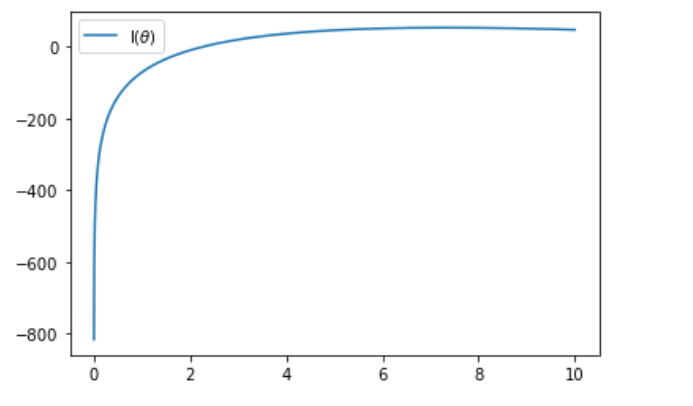
También máximice la función verosimilitud para encontrar el máximo $\lambda$ para la función verosimilitud y compare el valor númerico encontrado con el valor teórico calculado. Concluya. 

**Para calcular el valor de $\Gamma$ use el siguiente paquete**
```
import scipy.special as sps 

```

**Cálculo de ${\lambda}$**


Sabemos que $X_1,X_2,\cdots,X_n$ es una muestra de variables aleatorias independientes idénticamente distribuidas ∴ 

$$\overline{x}= {\displaystyle\sum_{i=1}^{n}(x_i)}$$

También se sabe que para una muestra $\overline{x}$ con observaciones $X \sim {\Gamma}(\alpha, \lambda)$ donde $\alpha$ es conocido y $\lambda$ desconocido la distribución conjunta es la siguiente:
$$f(x|\alpha,\lambda) = \prod_{i = 1}^{n} f(x|\alpha,\lambda) = \left(\frac{{\lambda}^{\alpha}}{\Gamma(\alpha)}\right)^{n} \prod_{i = 1}^{n} x_{i}^{\left(\alpha-1\right)}e^{-\lambda x_{i}}\alpha\lambda^{n\alpha} e^ {\left(-\lambda {\displaystyle\sum_{i=1}^{n}(x_i)}\right)}$$

Podemos justificar la eliminación de todos los factores que no son funciones de $\lambda$ si estamos interesados en la probabilidad de $\lambda$ con respecto a $x$ y $\alpha$ fijos. 

∴ La verosimilitud de $\lambda$ es proporcional a: $ℓ(\lambda|\alpha,x) \alpha$ $n \alpha$ $log \lambda$ - $\lambda n \overline{x}$ $\alpha$ $log \lambda$ - $\overline{x}\lambda$ 

donde la máxima verosimilitud tiene puntos críticos para $\lambda$ al derivar parcialmente satisfaciendo:

$0= \displaystyle \frac{\partial ℓ}{\partial \lambda} = \frac{n\alpha}{\lambda}-\overline{x}$

∴ $\lambda = \frac{n\alpha}{\overline{x}}$ 

Al sustituir $\overline{x}$ obtenemos finalmente que: $$\lambda = \frac{n\alpha}{\displaystyle\sum_{i=1}^{n}(x_i)}$$

In [39]:
#Variables
n=20
a=5.5
x=15
lnx=5
l= lambda θ: n*a*np.log(θ)-n*np.log(sps.gamma(a))+(a-1)*lnx-θ*x
ML= optimize.fmin(lambda x:-l(x), 0, disp=True)
theta= np.arange(0,10,.01)
ML, l(theta)[733]

Optimization terminated successfully.
         Current function value: -52.511039
         Iterations: 31
         Function evaluations: 62


(array([7.3333125]), 52.5110273964673)

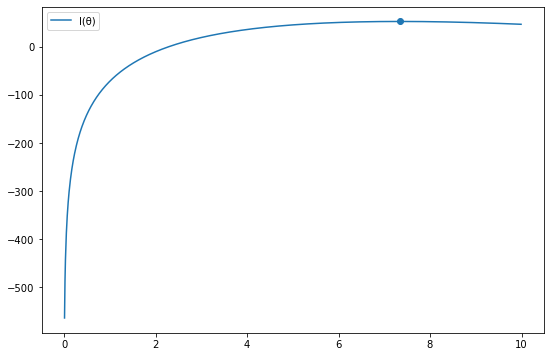

In [40]:
plt.figure(figsize = (9,6))
plt.plot(theta,l(theta), label='l(θ)')
plt.scatter(ML, l(theta)[733])
plt.legend(loc='best')
plt.show()

**Valor de los ejercicios**
- 1- 4 puntos
- 2- 2 puntos
- 3- 8 puntos
- 4- 2 puntos
- 5- 2 puntos


<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>